In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns
plt.rcParams['font.size'] = 10

!pip -q install pyswarm
from pyswarm import pso

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

In [15]:
import warnings
warnings.filterwarnings('ignore')

**About the Dataset:**

The dataset that we are going to use is arranged from two original data.
Real-time drilling data and a Computed Petrophysical Output (CPO) log data from well number 15/9-F-15 in the Volve Oil Field in the North Sea.

In [4]:
# Read from path to CSV file
path = 'https://raw.githubusercontent.com/yohanesnuwara/volve-machine-learning/main/Data_for_ROP_optimization.csv'
df = pd.read_csv(path)

df.head()

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
0,3305.0,26217.864,1.314720,0.004088,0.086711,0.071719,1.0,0.001
1,3310.0,83492.293,1.328674,0.005159,0.095208,0.116548,1.0,0.001
2,3315.0,97087.882,1.420116,0.005971,0.061636,0.104283,1.0,0.001
3,3320.0,54793.206,1.593931,0.005419,0.043498,0.110040,1.0,0.001
4,3325.0,50301.579,1.653262,0.005435,0.035252,0.120808,1.0,0.001


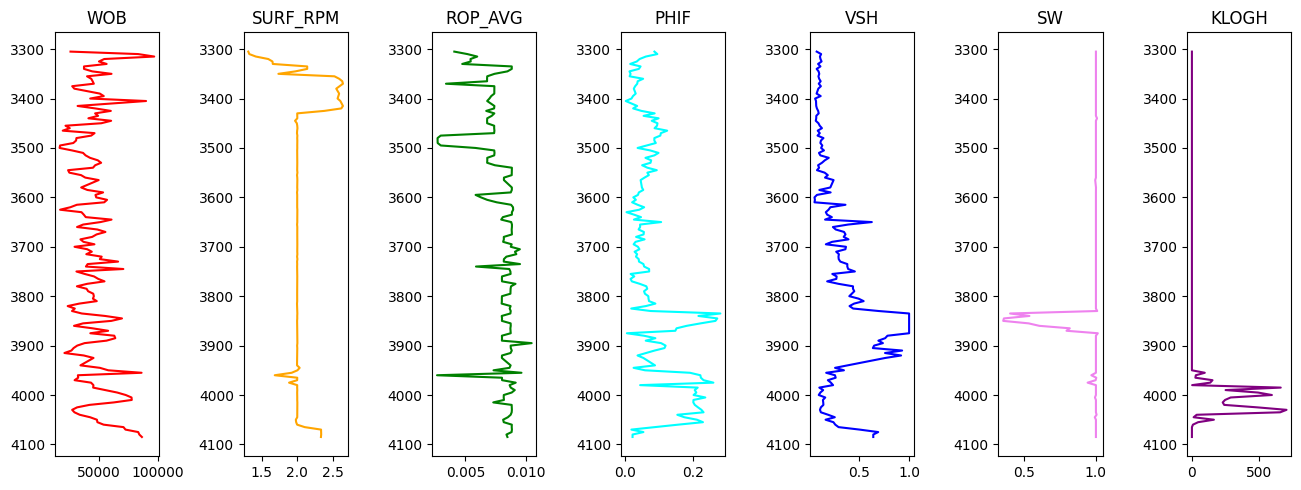

In [9]:
#Visualization of drilling and geophysical log data
#Display logs
logs = df.columns[1:]
colors = ['red', 'orange', 'green', 'cyan', 'blue', 'violet', 'purple']

plt.figure(figsize=(15,5))
for i in range(len(logs)):
  plt.subplot(1,8,i+1)
  plt.plot(df[logs[i]], df.Depth, color=colors[i])
  plt.title(logs[i])
  plt.gca().invert_yaxis()

plt.tight_layout()

Interval 3,480–3,500 m where the **ROP** drops to 0.002 m/s. This **sudden break** may be caused by two factors; expected or unexpected causes. The expected cause can be high formation pressure so that the driller avoids accidents. The unexpected cause is insufficient **WOB** and **RPM**.

Because we do not have details about formation pressure, we assume that this sudden break is unexpected. As we observe at depth 3,480 m, the **WOB** is about 31,000 N and RPM is 2 when the **ROP** drops to 0.002 m/s. We hypothesize that the **WOB** and **RPM** are insufficient to keep the **ROP** above.

**We will answer two questions in this Analysis:**



1.   What causes the ROP to suddenly drop at depth 3,480 m?
2.   What values of WOB and RPM are needed to optimize the ROP?




# **Gradient Boosting Machine for ROP prediction**

In [11]:
# Separate feature and target
X = df.drop(['ROP_AVG'], axis=1)
y = df['ROP_AVG']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Make pipeline
steps = [('scaler', StandardScaler()),
         ('gbr', GradientBoostingRegressor(min_samples_leaf=6, max_depth=20, random_state=10))]
pipe = Pipeline(steps)

# Fit pipeline to training data
pipe.fit(X_train,y_train)

# Evaluate model with R2 metric
train_score = pipe.score(X_train, y_train)
test_score = pipe.score(X_test, y_test)
print(f'R2 on train set: {train_score:.2f}')
print(f'R2 on test set: {test_score:.2f}')

R2 on train set: 0.98
R2 on test set: 0.77


In [13]:
def predict(model, Depth, PHIF, VSH, SW, KLOGH, WOB, SURF_RPM):
  # Make a test input
  X_test = np.array([Depth, WOB, SURF_RPM, PHIF, VSH, SW, KLOGH])
  X_test = X_test.reshape(1,-1)

  # Predict on a test input
  y_pred = model.predict(X_test)
  return y_pred[0]


In [16]:
# Predict on new inputs
predict(pipe, 4000, 0.2, 0.5, 1, 500, WOB=5e4, SURF_RPM=2)

0.008385100886684715

## **Optimization using Particle Swarm**

To **optimize** the **ROP** at depth 3,480 m where the **sudden break of ROP occurs**. We used the model to generate a “prediction space” of ROP as a function of WOB and RPM. To do this, we make a **range** of **WOB** and **RPM** values and keep other input variables constant. The constant input variables are those obtained from our data at 3,480 m.

**Depth**: 3,480 m

**PHIF**: 0.09

**VSH**: 0.1

**SW**: 1

**KLOGH**: 0.01 md

**WOB**: range (17,000–90,000) N

**RPM**: range (1.5–2.5)

In [17]:

def plot_space(model, WOB, SURF_RPM, constant_inputs):
  N_matrix = np.empty((len(WOB), len(SURF_RPM)))
  for i in range(len(WOB)):
    for j in range(len(SURF_RPM)):
      # Unwrap constant variables
      Depth, PHIF, VSH, SW, KLOGH = constant_inputs.values()
      N = predict(model, Depth, PHIF, VSH, SW, KLOGH, WOB=WOB[i], SURF_RPM=SURF_RPM[j])
      N_matrix[i][j] = N

  plt.imshow(N_matrix, origin='lower', aspect='auto', cmap='inferno',
             extent=(min(SURF_RPM), max(SURF_RPM), min(WOB), max(WOB)))
  plt.xlabel('SURF_RPM')
  plt.ylabel('WOB')
  plt.title('ROP_AVG', pad=10)
  plt.colorbar()

In [18]:
# Range of WOB and RPM values
WOB = np.linspace(17e3, 90e3, 30)
SURF_RPM = np.linspace(1.5, 2.5, 30)

# Constant input variables
constant_inputs = {'Depth': 3480, 'PHIF': 0.09, 'VSH': 0.1,
                   'SW': 1, 'KLOGH': 0.001}


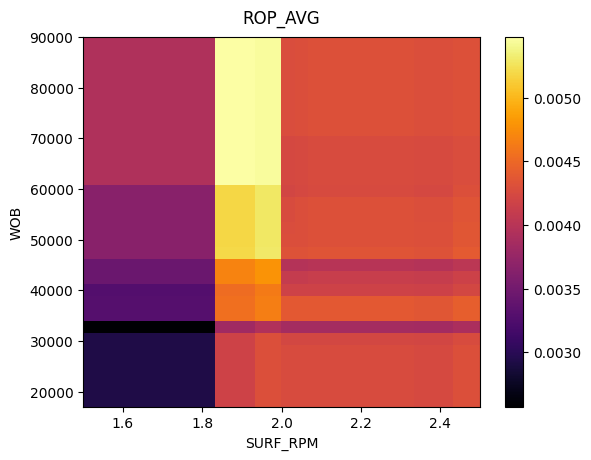

In [19]:
# Plot prediction space
plot_space(pipe, WOB, SURF_RPM, constant_inputs)

In [28]:
# Data at depth 3480 m
df[df.Depth==3480]

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
33,3480.0,31236.811,1.999362,0.00271,0.086571,0.139695,1.0,0.001


From this plot, we see that at depth 3,480 m, **high ROP** is achieved at **WOB** above 42,000 N and **RPM** ranges from 1.8 to 2.

We can clearly find the reason why the **ROP drops**! In the data, we knew that the **WOB** is only 31,000 N, which is below the accepted window of WOB to optimize the ROP.

**Conclusion**

We have shown how to use **Gradient Boosting Machine** and **Particle Swarm Optimization** to **optimize** the **Rate of Penetration in drilling**.



1.   The **ROP** drops down to 0.002 m/s at depth 3,480 m because of an **insufficient** WOB of 31,000 N.
2.   The most **optimum** **ROP** at depth 3,480 m is 0.0055 m. It can be **achieved** with a WOB of approximately 74,000 N and RPM 2.


In the future, problems such as **sudden breaks** in drilling could be avoided by doing **optimization** in the line.

In [59]:
import pyswarm as pso

# Define objective function. "pipe" as model
def f(X):
    return -pipe.predict(X.reshape(1,-1)) # Minus sign to optimize

# Lower bounds of feature variables in the order of X.columns
lb = np.array([3480, 2e4, 1.5, 0.09, 0.1, 1, 0.001])

# Upper bounds of feature variables in the order of X.columns
ub = np.array([3480, 9e4, 2.5, 0.09, 0.1, 1, 0.001])
# ub += 1e-10

# Solve optimization
xopt, fopt = pso(f, lb, ub, swarmsize=200, omega=0.3, phip=.5, phig=0.7, maxiter=1000, minstep=1e-8)

# Print values that causes maximum ROP from xopt
for i in range(len(X.columns)):
  print(f'{X.columns[i]}: {xopt[i]:.2f}')

# Print value of maximum ROP from popt
print(f'Maximum ROP achieved: {-fopt}')